In [1]:
import pandas as pd
from torch.utils.data import DataLoader,Dataset, Subset
import numpy as np
import tft_model
from data_formatters import ts_dataset  
import data_formatters.base
import expt_settings.configs
import importlib
from data_formatters import utils
import torch.optim as optim


In [2]:
pd.set_option('max_columns', 1000)

In [197]:
importlib.reload(tft_model)
importlib.reload(utils)

<module 'data_formatters.utils' from '/Users/matthewsherar/Developer/Temporal Fusion Transformer/data_formatters/utils.py'>

In [85]:
ExperimentConfig = expt_settings.configs.ExperimentConfig

config = ExperimentConfig('electricity', 'outputs')
data_formatter = config.make_data_formatter()


print("*** Training from defined parameters for {} ***".format('electricity'))
data_csv_path = 'data/hourly_electricity.csv'
print("Loading & splitting data...")
raw_data = pd.read_csv(data_csv_path, index_col=0)
train, valid, test = data_formatter.split_data(raw_data)
train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
)

# Sets up default params
fixed_params = data_formatter.get_experiment_params()
params = data_formatter.get_default_model_params()

*** Training from defined parameters for electricity ***
Loading & splitting data...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Formatting train-valid-test splits.
Setting scalers with training data...


In [5]:
len(train.id.unique())

369

In [6]:
id_col = 'categorical_id'
time_col='hours_from_start'
input_cols =['power_usage', 'hour', 'day_of_week', 'hours_from_start', 'categorical_id']
target_col = 'power_usage'
time_steps=192
num_encoder_steps = 168
output_size = 1
max_samples = 5000
input_size = 5

elect = ts_dataset.TSDataset(id_col, time_col, input_cols,
                      target_col, time_steps, max_samples,
                     input_size, num_encoder_steps, output_size, train)

Getting valid sampling locations.
Extracting 5000 samples...


In [7]:
batch_size=64
loader = DataLoader(
            elect,
            batch_size=batch_size,
            num_workers=2,
            shuffle=True
        )

In [8]:
for batch in loader:
    break

In [219]:
static_cols = ['meter']
categorical_cols = ['hour']
real_cols = ['power_usage','hour', 'day']
config = {}
config['static_variables'] = len(static_cols)
config['time_varying_categoical_variables'] = 1
config['time_varying_real_variables_encoder'] = 4
config['time_varying_real_variables_decoder'] = 3
config['num_masked_series'] = 1
config['static_embedding_vocab_sizes'] = [369]
config['time_varying_embedding_vocab_sizes'] = [369]
config['embedding_dim'] = 16
config['lstm_hidden_dimension'] = 160
config['lstm_layers'] = 2
config['dropout'] = 0.05
config['device'] = 'cpu'
config['batch_size'] = 64
config['encode_length'] = 168
config['attn_heads'] = 4
config['num_quantiles'] = 3
config['vailid_quantiles'] = [0.1,0.5,0.9]

In [220]:
model = tft_model.TFT(config)

In [200]:
output,encoder_output, decoder_output, attn = model.forward(batch)

In [201]:
output[0,0,:]

tensor([-0.2933,  0.3621, -0.1455], grad_fn=<SliceBackward>)

In [202]:
import matplotlib.pyplot as plt

In [171]:
attn_output_weights.shape

torch.Size([64, 192, 192])

In [172]:
attn.shape

torch.Size([24, 64, 160])

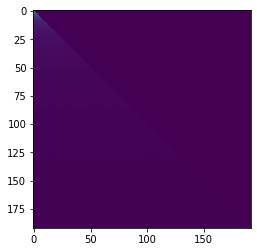

In [173]:
plt.imshow(attn_output_weights[20,:,:].detach().numpy())

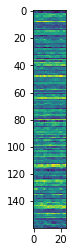

In [183]:
plt.imshow(decoder_output[:,0].detach().numpy().T)

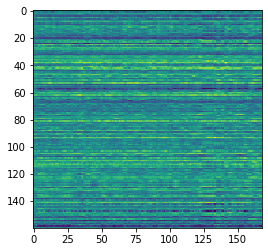

In [184]:
plt.imshow(encoder_ouput[:,0].detach().numpy().T)

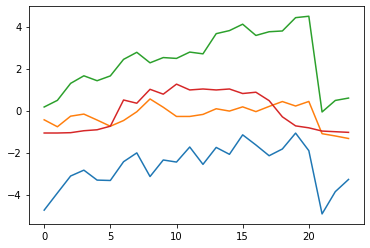

In [191]:
plt.plot(output[14,:,:].detach().numpy())
plt.plot(batch['outputs'][14,:,0].detach().numpy())

In [177]:
output[0,:,:]

tensor([[ 0.5000,  1.0761, -0.1484],
        [ 0.2685,  0.5095, -0.1417],
        [ 0.4571,  0.9171,  0.0942],
        [ 0.5639,  0.9280,  0.0336],
        [ 0.1473,  0.4606, -0.3771],
        [ 0.4717,  0.0259,  0.0369],
        [ 0.4642,  1.0188, -0.2301],
        [ 0.3654,  0.6631, -0.1446],
        [ 0.2220,  0.5162, -0.3351],
        [-0.0723,  0.7407, -0.3501],
        [ 0.0496,  0.6873, -0.2730],
        [-0.0918,  0.3979,  0.0474],
        [ 0.0720,  0.5186, -0.1957],
        [ 0.4005,  0.2380, -0.4518],
        [ 0.4807,  0.6312, -0.3162],
        [ 0.8552,  1.2652, -0.4443],
        [ 0.2291,  0.3236,  0.0524],
        [ 0.4530,  0.0481,  0.1644],
        [ 0.2164,  0.4571, -0.1112],
        [ 0.3262,  0.4387, -0.2001],
        [-0.1440,  0.4609,  0.3854],
        [ 0.5799,  0.9012,  0.1216],
        [-0.0672,  0.7408, -0.0721],
        [ 0.2586,  0.1309, -0.3809]], grad_fn=<SliceBackward>)

In [178]:
q_loss_func(output[:,:,:].view(-1,3), batch['outputs'][:,:,0].flatten().float())

tensor(1.3542, grad_fn=<MeanBackward0>)

In [179]:
output.shape

torch.Size([64, 24, 3])

In [203]:
q_loss_func = tft_model.QuantileLoss([0.1,0.5,0.9])

In [204]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()
epochs=15
losses = []
for i in range(epochs):
    epoch_loss = [] 
    j=0
    for batch in loader:
        output, encoder_ouput, decoder_output, attn = model(batch)
        loss= q_loss_func(output[:,:,:].view(-1,3), batch['outputs'][:,:,0].flatten().float())
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        j+=1
        if j>50:
            break
    losses.append(np.mean(epoch_loss))
    print(np.mean(epoch_loss))
    

1.30588007440754
1.2851863491768931
1.2190520225786696
1.1626571229859894
1.1288055578867595
1.069309275524289
0.933530495447271
0.8807998591778325
0.7778564878538543
0.901652758027993


KeyboardInterrupt: 

In [206]:
output, encoder_ouput, decoder_output, attn = model(batch)


3


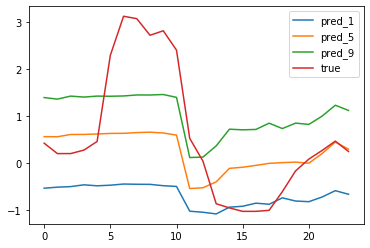

In [218]:
import matplotlib.pyplot as plt
import numpy as np

ind = np.random.choice(64)
print(ind)
plt.plot(output[ind,:,0].detach().cpu().numpy(), label='pred_1')
plt.plot(output[ind,:,1].detach().cpu().numpy(), label='pred_5')
plt.plot(output[ind,:,2].detach().cpu().numpy(), label='pred_9')

plt.plot(batch['outputs'][ind,:,0], label='true')
plt.legend()